<a href="https://colab.research.google.com/github/CalvinXKY/EPLB_visualization/blob/main/EPLB_visualization_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

版本v1：修复索引溢出的bug

In [1]:
from typing import Tuple
import numpy as np


def balanced_packing(weight: list, num_packs: int) -> Tuple[list, list]:
    """
    Pack n weighted objects to m packs, such that each bin contains exactly n/m objects and the weights of all packs
    are as balanced as possible.

    Parameters:
        weight: [X, n], the weight of each item (as nested list)
        num_packs: number of packs

    Returns:
        pack_index: [X, n], the pack index of each item
        rank_in_pack: [X, n], the rank of the item in the pack
    """
    num_layers = len(weight)
    num_groups = len(weight[0])
    assert num_groups % num_packs == 0
    groups_per_pack = num_groups // num_packs

    if groups_per_pack == 1:
        pack_index = [[j for j in range(num_groups)] for _ in range(num_layers)]
        rank_in_pack = [[0 for _ in range(num_groups)] for _ in range(num_layers)]
        return pack_index, rank_in_pack

    # 初始化输出列表
    pack_index = [[-1 for _ in range(num_groups)] for _ in range(num_layers)]
    rank_in_pack = [[-1 for _ in range(num_groups)] for _ in range(num_layers)]

    for i in range(num_layers):
        # 对每层的权重进行排序
        sorted_indices = np.argsort([-x for x in weight[i]])
        pack_weights = [0] * num_packs
        pack_items = [0] * num_packs

        for group in sorted_indices:
            # 找到当前最轻的包
            pack = min((j for j in range(num_packs) if pack_items[j] < groups_per_pack),
                       key=lambda x: pack_weights[x])
            assert pack_items[pack] < groups_per_pack
            pack_index[i][group] = pack
            rank_in_pack[i][group] = pack_items[pack]
            pack_weights[pack] += weight[i][group]
            pack_items[pack] += 1

    return pack_index, rank_in_pack


def replicate_experts(weight: list, num_phy: int) -> Tuple[list, list, list]:
    """
    Replicate `num_log` experts to `num_phy` replicas, such that the maximum load of all replicas is minimized.

    Parameters:
        weight: [X, num_log] as nested list
        num_phy: total number of experts after replication

    Returns:
        phy2log: [X, num_phy], logical expert id of each physical expert
        rank: [X, num_phy], the replica rank
        logcnt: [X, num_log], number of replicas for each logical expert
    """
    n = len(weight)
    num_log = len(weight[0])
    num_redundant = num_phy - num_log
    assert num_redundant >= 0

    # 初始化输出列表
    phy2log = [[i for i in range(num_phy)] for _ in range(n)]
    rank = [[0 for _ in range(num_phy)] for _ in range(n)]
    logcnt = [[1 for _ in range(num_log)] for _ in range(n)]

    for i in range(num_log, num_phy):
        for layer in range(n):
            # 计算每个专家的平均负载
            avg_loads = [weight[layer][j] / logcnt[layer][j] for j in range(num_log)]
            redundant_index = avg_loads.index(max(avg_loads))

            phy2log[layer][i] = redundant_index
            rank[layer][i] = logcnt[layer][redundant_index]
            logcnt[layer][redundant_index] += 1

    return phy2log, rank, logcnt


def inverse(perm: list) -> list:
    """将排列转换为其逆排列"""
    n_rows = len(perm)
    n_cols = len(perm[0])
    inv = [[-1 for _ in range(n_cols)] for _ in range(n_rows)]
    for i in range(n_rows):
        for j in range(n_cols):
            inv[i][perm[i][j]] = j
    return inv


def rebalance_experts_hierarchical(weight: list, num_physical_experts: int,
                                   num_groups: int, num_nodes: int, num_gpus: int):
    """
    Parameters:
        weight: [num_moe_layers, num_logical_experts] as nested list
        num_physical_experts: number of physical experts after replication
        num_groups: number of expert groups
        num_nodes: number of server nodes, where the intra-node network (e.g, NVLink) is faster
        num_gpus: number of GPUs, must be a multiple of `num_nodes`

    Returns:
        physical_to_logical_map: [num_moe_layers, num_physical_experts]
        logical_to_physical_map: [num_moe_layers, num_logical_experts, X]
        logical_count: [num_moe_layers, num_logical_experts]
    """
    num_layers = len(weight)
    num_logical_experts = len(weight[0])
    assert num_logical_experts % num_groups == 0
    group_size = num_logical_experts // num_groups
    assert num_groups % num_nodes == 0
    groups_per_node = num_groups // num_nodes
    assert num_gpus % num_nodes == 0
    assert num_physical_experts % num_gpus == 0
    phy_experts_per_gpu = num_physical_experts // num_gpus

    # Step 1: pack groups to nodes
    # 计算每个组的总权重
    tokens_per_group = [[0 for _ in range(num_groups)] for _ in range(num_layers)]
    for i in range(num_layers):
        for j in range(num_groups):
            start_idx = j * group_size
            end_idx = start_idx + group_size
            tokens_per_group[i][j] = sum(weight[i][start_idx:end_idx])

    group_pack_index, group_rank_in_pack = balanced_packing(tokens_per_group, num_nodes)

    # 构建log2mlog映射
    log2mlog = [[0 for _ in range(num_logical_experts)] for _ in range(num_layers)]
    for i in range(num_layers):
        for g in range(num_groups):
            for k in range(group_size):
                idx = g * group_size + k
                node = group_pack_index[i][g]
                rank = group_rank_in_pack[i][g]
                log2mlog[i][idx] = (node * groups_per_node + rank) * group_size + k

    mlog2log = inverse(log2mlog)

    # Step 2: construct redundant experts within nodes
    tokens_per_mlog = [[0 for _ in range(num_logical_experts // num_nodes)]
                       for _ in range(num_layers * num_nodes)]
    for i in range(num_layers):
        for j in range(num_logical_experts):
            node_idx = j // (num_logical_experts // num_nodes)
            local_idx = j % (num_logical_experts // num_nodes)
            layer_node_idx = i * num_nodes + node_idx
            tokens_per_mlog[layer_node_idx][local_idx] = weight[i][mlog2log[i][j]]

    phy2mlog, phyrank, mlogcnt = replicate_experts(
        tokens_per_mlog, num_physical_experts // num_nodes)

    # Step 3: pack physical experts to GPUs
    tokens_per_phy = [[0 for _ in range(num_physical_experts // num_nodes)]
                      for _ in range(num_layers * num_nodes)]
    for i in range(len(tokens_per_mlog)):
        for j in range(len(phy2mlog[i])):
            mlog_idx = phy2mlog[i][j]
            tokens_per_phy[i][j] = tokens_per_mlog[i][mlog_idx] / mlogcnt[i][mlog_idx]

    pack_index, rank_in_pack = balanced_packing(tokens_per_phy, num_gpus // num_nodes)

    # 构建最终映射
    phy2pphy = [[pack_index[i][j] * phy_experts_per_gpu + rank_in_pack[i][j]
                 for j in range(len(pack_index[i]))]
                for i in range(len(pack_index))]
    pphy2phy = inverse(phy2pphy)

    # 整合结果
    pphy2log = [[0 for _ in range(num_physical_experts)] for _ in range(num_layers)]
    pphyrank = [[0 for _ in range(num_physical_experts)] for _ in range(num_layers)]
    logcnt = [[0 for _ in range(num_logical_experts)] for _ in range(num_layers)]

    for i in range(num_layers):
        for j in range(num_physical_experts):
            node_idx = j // (num_physical_experts // num_nodes)
            local_idx = j % (num_physical_experts // num_nodes)
            layer_node_idx = i * num_nodes + node_idx

            mlog_idx = phy2mlog[layer_node_idx][pphy2phy[layer_node_idx][local_idx]]
            global_mlog_idx = node_idx * (num_logical_experts // num_nodes) + mlog_idx
            pphy2log[i][j] = mlog2log[i][global_mlog_idx]
            pphyrank[i][j] = phyrank[layer_node_idx][pphy2phy[layer_node_idx][local_idx]]

        for j in range(num_logical_experts):
            logcnt[i][j] = mlogcnt[i // num_nodes][log2mlog[i][j] % (num_logical_experts // num_nodes)]

    return pphy2log, pphyrank, logcnt


def rebalance_experts(weight: list, num_replicas: int, num_groups: int,
                      num_nodes: int, num_gpus: int) -> Tuple[list, list, list]:
    """
    Entry point for expert-parallelism load balancer.

    Parameters:
        weight: [layers, num_logical_experts], the load statistics for all logical experts
        num_replicas: number of physical experts, must be a multiple of `num_gpus`
        num_groups: number of expert groups
        num_nodes: number of server nodes, where the intra-node network (e.g, NVLink) is faster
        num_gpus: number of GPUs, must be a multiple of `num_nodes`

    Returns:
        physical_to_logical_map: [layers, num_replicas], the expert index of each replica
        logical_to_physical_map: [layers, num_logical_experts, X], the replica indices for each expert
        expert_count: [layers, num_logical_experts], number of physical replicas for each logical expert
    """
    if num_groups % num_nodes == 0:
        # use hierarchical load-balance policy
        phy2log, phyrank, logcnt = rebalance_experts_hierarchical(
            weight, num_replicas, num_groups, num_nodes, num_gpus)
    else:
        # use global load-balance policy
        phy2log, phyrank, logcnt = replicate_experts(weight, num_replicas)

    maxlogcnt = max(max(cnt) for cnt in logcnt)
    num_layers = len(weight)
    num_logical_experts = len(weight[0])

    # 确保log2phy的维度正确
    log2phy = [[[-1 for _ in range(maxlogcnt)]
                for _ in range(num_logical_experts)]
               for _ in range(num_layers)]

    for i in range(num_layers):
        for j in range(num_replicas):
            log_idx = phy2log[i][j]
            rank_idx = phyrank[i][j]
            # 确保rank_idx在有效范围内
            if rank_idx < maxlogcnt:
                log2phy[i][log_idx][rank_idx] = j
            else:
                # 处理超出范围的情况，例如记录错误或调整rank_idx
                print(f"Warning: rank_idx {rank_idx} is out of range for log_idx {log_idx} in layer {i}")

    return phy2log, log2phy, logcnt


__all__ = ['rebalance_experts']

In [2]:
# 创建可视化函数：

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


def visualize_4d_array(arr):
    """
    Draw a hierarchical diagram of a 4D array.

    Parameters:
        arr: 4D array with shape [dim0, dim1, dim2, dim3]
    """
    dim0 = len(arr)
    dim1 = len(arr[0]) if dim0 > 0 else 0
    dim2 = len(arr[0][0]) if dim1 > 0 else 0
    dim3 = len(arr[0][0][0]) if dim2 > 0 else 0

    # Count value frequencies per row
    value_counts_per_row = {}
    for i in range(dim0):
        value_counts = {}
        for j in range(dim1):
            for k in range(dim2):
                for l in range(dim3):
                    value = arr[i][j][k][l]
                    if value in value_counts:
                        value_counts[value] += 1
                    else:
                        value_counts[value] = 1
        value_counts_per_row[i] = value_counts

    # Assign colors to repeated values per row
    repeated_values_per_row = {}
    color_maps_per_row = {}
    for i in range(dim0):
        value_counts = value_counts_per_row[i]
        repeated_values = {value: idx for idx, value in enumerate([k for k, v in value_counts.items() if v > 1])}
        num_repeated = len(repeated_values)
        if num_repeated > 0:
            cmap = plt.cm.tab20
            norm = plt.Normalize(vmin=0, vmax=num_repeated - 1)
            color_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        else:
            color_map = None
        repeated_values_per_row[i] = repeated_values
        color_maps_per_row[i] = color_map

    # Set figure size
    plt.figure(figsize=(15, 6))

    # Calculate layout parameters
    total_width = 12
    cell_width = total_width / dim1
    cell_height = 0.8
    block_width = cell_width * 0.8 / dim2
    block_height = cell_height * 0.8
    sub_block_width = block_width * 0.8 / dim3
    sub_block_height = block_height * 0.8

    # Draw grid
    for i in range(dim0):
        for j in range(dim1):
            x = j * cell_width
            y = (dim0 - 1 - i) * cell_height
            rect = patches.Rectangle((x, y), cell_width * 0.9, cell_height * 0.9,
                                     facecolor='lightgray', edgecolor='black', alpha=0.3)
            plt.gca().add_patch(rect)

            if j == 0:
                label_x = x - cell_width * 0.1
                label_y = y + cell_height * 0.5
                plt.text(label_x, label_y, f'Layer {i}', ha='right', va='center', fontsize=20, color='black',
                         rotation=90)

            if i == dim0 - 1:
                label_x = x + cell_width * 0.5
                label_y = y - cell_height * 0.1
                plt.text(label_x, label_y, f'Node {j}', ha='center', va='top', fontsize=20, color='black')

            for k in range(dim2):
                block_x = x + k * block_width + cell_width * 0.05
                block_y = y + cell_height * 0.05

                rect_block = patches.Rectangle((block_x, block_y), block_width * 0.9, block_height * 0.9,
                                               facecolor='none', edgecolor='black', alpha=0.3,
                                               linestyle='dashed')
                plt.gca().add_patch(rect_block)

                plt.text(block_x + block_width * 0.1, block_y + block_height * 0.9,
                         f'GPU {k}', ha='left', va='top', fontsize=8, color='black')

                for l in range(dim3):
                    sub_block_x = block_x + l * sub_block_width + block_width * 0.05
                    sub_block_y = block_y + block_height * 0.05

                    value = arr[i][j][k][l]

                    repeated_values = repeated_values_per_row[i]
                    color_map = color_maps_per_row[i]

                    if value in repeated_values:
                        if color_map:
                            color = color_map.to_rgba(repeated_values[value])
                        else:
                            color = 'gray'
                    else:
                        color = 'none'

                    rect_sub_block = patches.Rectangle((sub_block_x, sub_block_y), sub_block_width * 0.9,
                                                       sub_block_height * 0.9,
                                                       facecolor=color, edgecolor='black', alpha=0.7)
                    plt.gca().add_patch(rect_sub_block)

                    plt.text(sub_block_x + sub_block_width * 0.45, sub_block_y + sub_block_height * 0.45,
                             f'{value}', ha='center', va='center', fontsize=16)

    for i in range(dim0 - 1):
        y_pos = (dim0 - 1 - i) * cell_height
        x_start = (0 * cell_width) - cell_width * 0.1
        plt.plot([x_start, total_width], [y_pos, y_pos], linestyle='dashed', color='black')

    plt.xlim(-0.5, total_width)
    plt.ylim(-0.5, dim0 * cell_height + 0.5)
    plt.axis('off')
    plt.title('EPLB Visualization     ---(@kaiyuan)')

    plt.tight_layout()
    plt.show()

def visualize_ep_inputs(weight):
    """
    Visualize experts inputs
    weight: [layers, num_logical_experts], the load statistics for all logical experts
    """
    # Determine array dimensions

    if not isinstance(weight, np.ndarray):
      weight = np.array(weight)
    dim0, dim1 = weight.shape

    # Handle empty array case
    if dim0 == 0 or dim1 == 0:
        print("Empty array provided.")
        return

    # Compute color mapping
    values = weight.flatten()
    max_val = np.max(values)
    min_val = np.min(values)

    # Set color map
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=min_val, vmax=max_val)
    color_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    # Set up plot
    plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)

    # Calculate layout parameters
    total_width = 12
    cell_width = total_width / dim1
    cell_height = 1.2

    # Draw each element
    for i in range(dim0):
        for j in range(dim1):
            x = j * cell_width
            y = (dim0 - 1 - i) * cell_height

            # Draw rectangle
            rect = patches.Rectangle((x, y), cell_width * 0.9, cell_height * 0.9,
                                     facecolor=color_map.to_rgba(weight[i][j]),
                                     edgecolor='black', alpha=0.7)
            ax.add_patch(rect)

            # Add text with larger font and black color
            text_x = x + cell_width * 0.45
            text_y = y + cell_height * 0.45
            ax.text(text_x, text_y, f'EP_{j}: {weight[i][j]}',
                    ha='center', va='center', fontsize=10, color='black')

            # Add layer label in first column
            if j == 0:
                label_x = x - cell_width * 0.1
                label_y = y + cell_height * 0.5
                ax.text(label_x, label_y, f'Layer {i}',
                        ha='right', va='center', fontsize=12, color='black', rotation=90)

        # Add dashed lines between layers
        if i < dim0 - 1:
            y_pos = (dim0 - 1 - i) * cell_height
            x_start = -cell_width * 0.1
            x_end = total_width
            ax.plot([x_start, x_end], [y_pos, y_pos], linestyle='dashed', color='black')

    # Set axis limits and style
    ax.set_xlim(-0.5, total_width)
    ax.set_ylim(-0.5, dim0 * cell_height + 0.5)
    ax.axis('off')
    ax.set_title('EP Weights Visualization     ---(@kaiyuan)')

    # Add colorbar
    plt.colorbar(color_map, ax=ax, label='Value')

    plt.tight_layout()
    plt.show()

def reshape_map(phy2log, num_nodes, num_gpus):
  np_phy2log = np.array(phy2log, dtype=int)
  np_phy2log = np_phy2log.reshape(np_phy2log.shape[0], num_nodes, int(num_gpus/num_nodes), int(np_phy2log.shape[-1]/num_gpus))
  return np_phy2log


In [4]:

weight = [[ 90, 132,  40,  61, 104, 165,  39,   4],
      [ 20, 107, 104,  64,  19, 197, 187, 157 ],
      [ 100, 107, 104,  64,  20, 197, 187, 157]]

num_replicas = 24
num_groups = 2
num_nodes = 2
num_gpus = 8

phy2log, log2phy, logcnt = rebalance_experts(weight, num_replicas, num_groups, num_nodes, num_gpus)
np_phy2log = reshape_map(phy2log, num_nodes, num_gpus)
print(phy2log)

[[3, 1, 1, 3, 1, 2, 0, 0, 2, 0, 1, 1, 5, 5, 7, 5, 4, 4, 5, 4, 6, 5, 4, 6], [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 0, 7, 5, 6, 7, 5, 4, 7, 6, 6, 5, 5, 6], [2, 0, 1, 2, 3, 1, 2, 3, 1, 0, 0, 1, 7, 5, 6, 7, 5, 4, 7, 6, 6, 5, 5, 6]]


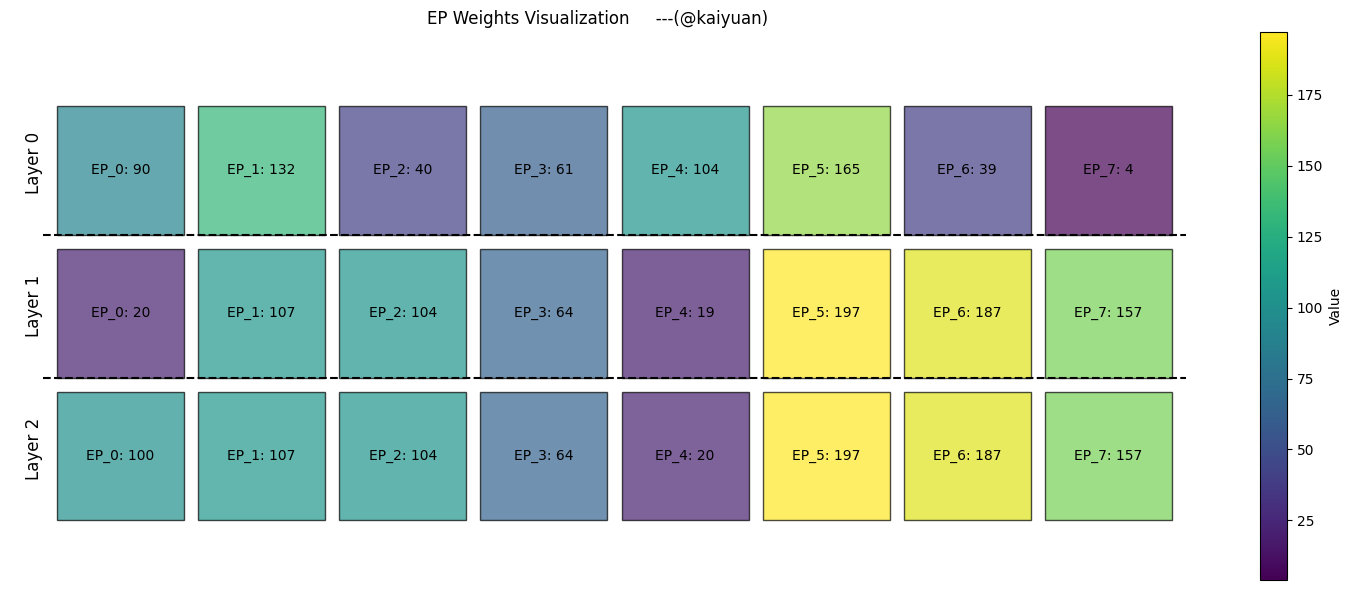

In [5]:
visualize_ep_inputs(weight)

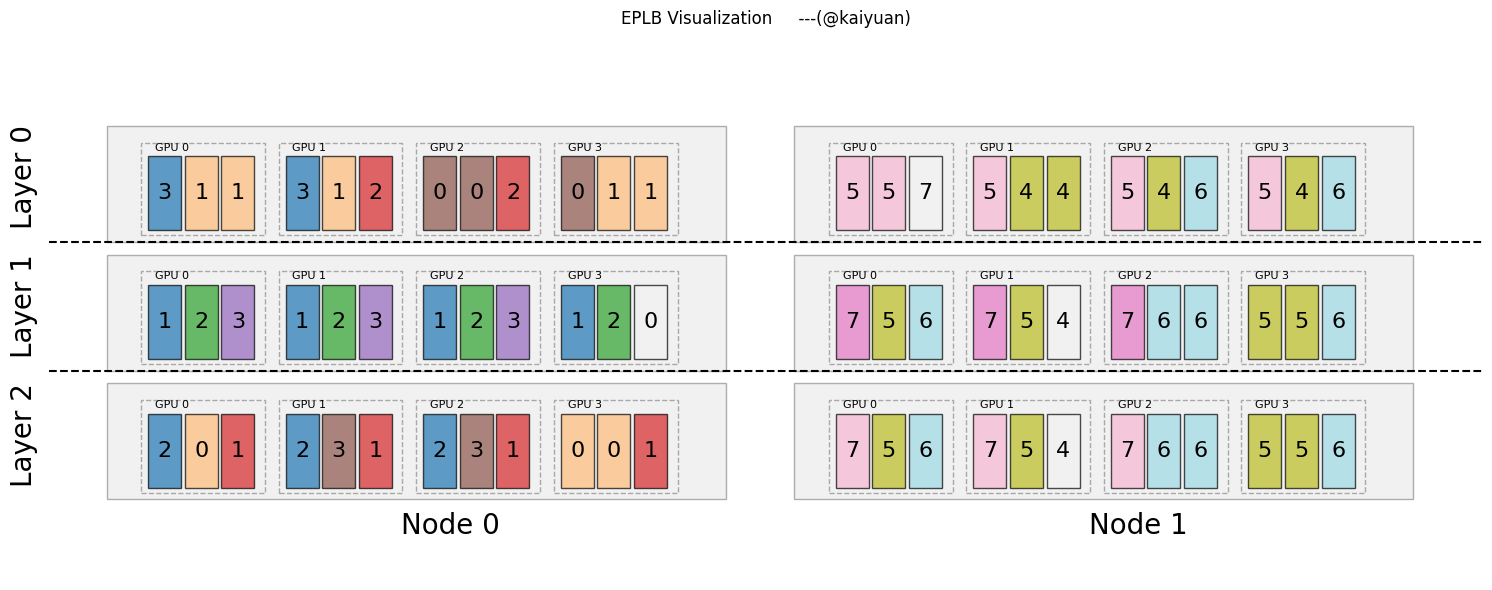

In [6]:
visualize_4d_array(np_phy2log)

[[0, 1, 2, 1, 3, 4, 5, 5]]


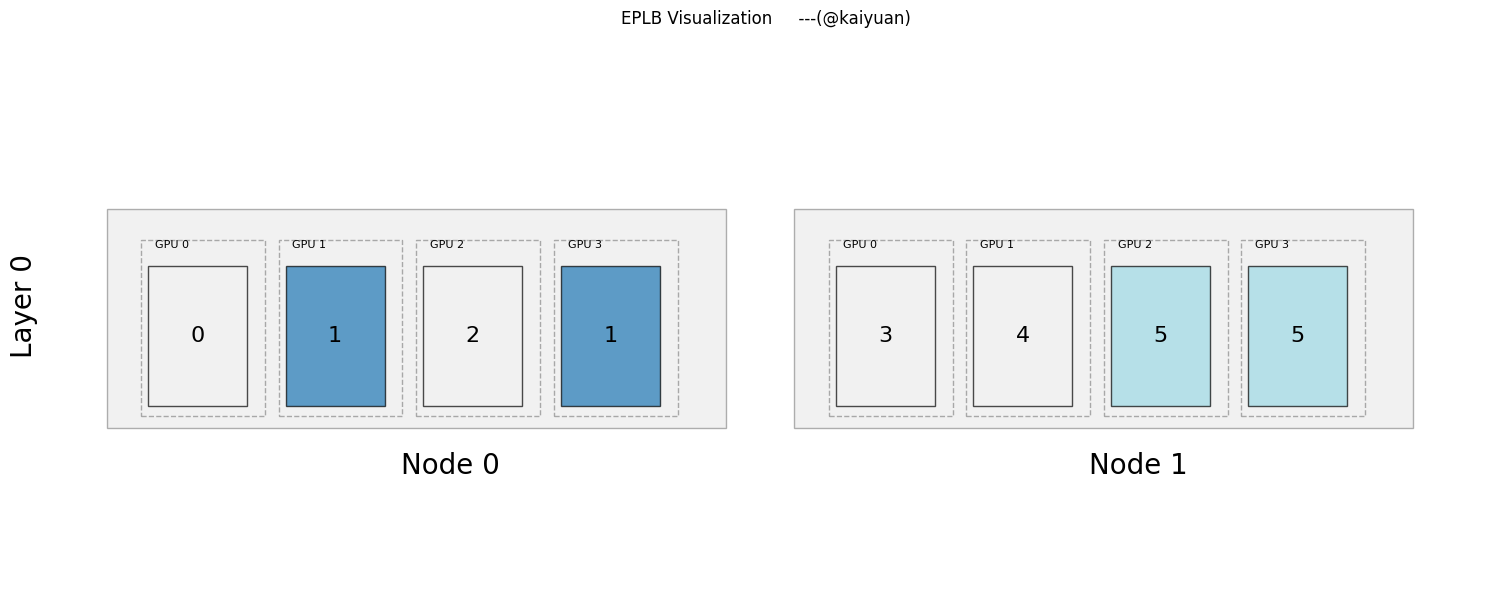

In [7]:
weight = [[ 90, 132,  40,  61, 104, 165]]

num_replicas = 8
num_groups = 2
num_nodes = 2
num_gpus = 8

phy2log, log2phy, logcnt = rebalance_experts(weight, num_replicas, num_groups, num_nodes, num_gpus)
np_phy2log = reshape_map(phy2log, num_nodes, num_gpus)
print(phy2log)
visualize_4d_array(np_phy2log)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 10, 5, 1, 4]]


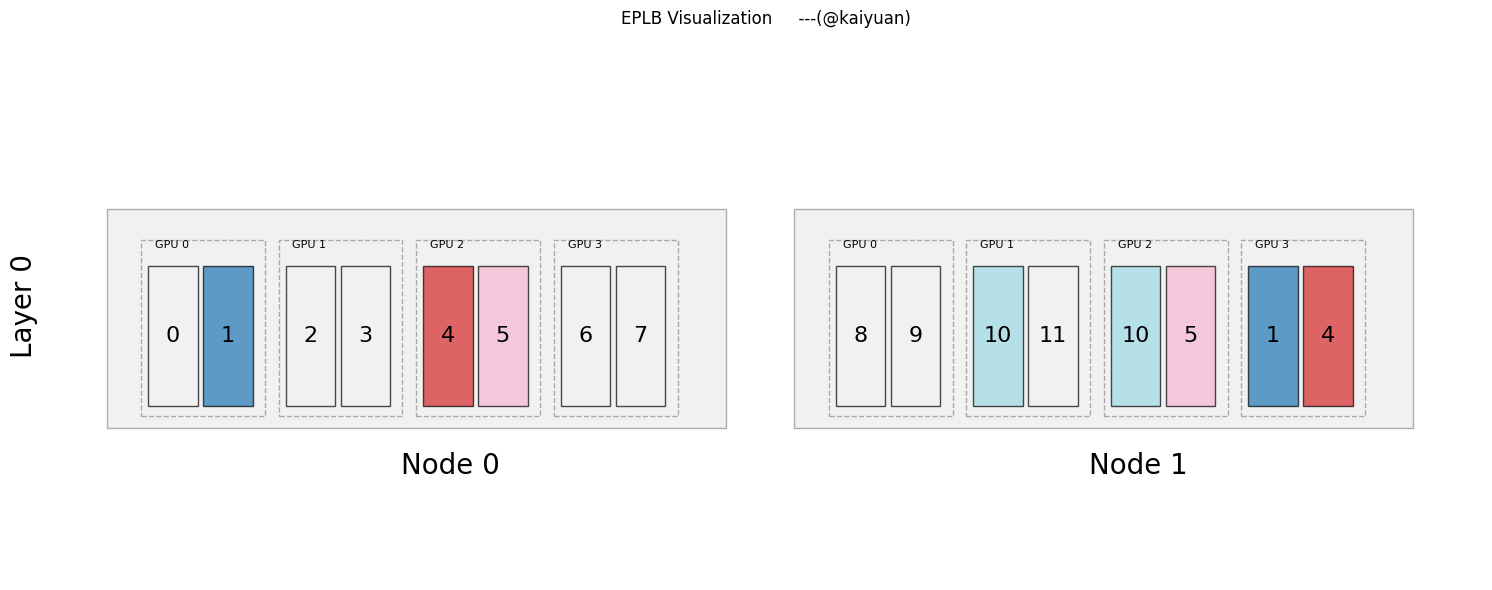

In [8]:
weight = [[ 90, 132,  40,  61, 104, 165,  39,   4,  73,  56, 183,  86]]

num_replicas = 16
# 大EP
num_groups = 1
num_nodes = 2
num_gpus = 8

phy2log, log2phy, logcnt = rebalance_experts(weight, num_replicas, num_groups, num_nodes, num_gpus)
np_phy2log = reshape_map(phy2log, num_nodes, num_gpus)
print(phy2log)
visualize_4d_array(np_phy2log)

[[5, 6, 5, 7, 8, 4, 3, 4, 10, 9, 10, 2, 0, 1, 11, 1]]


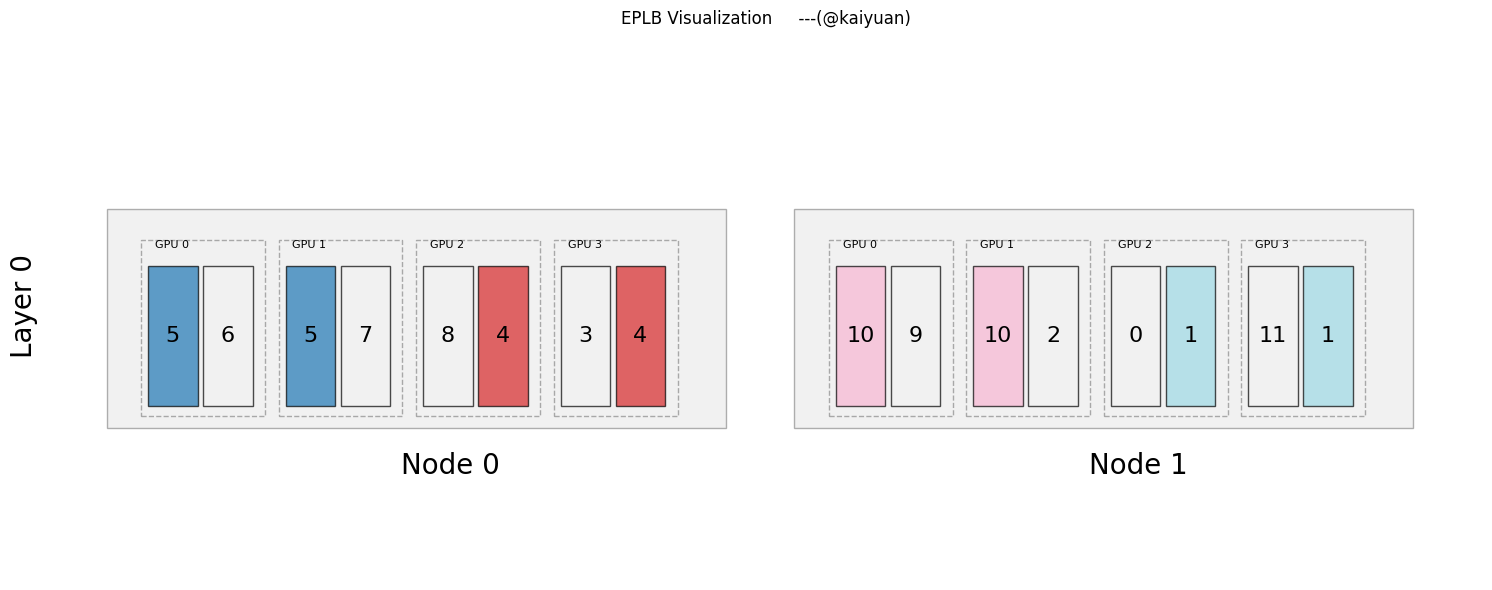

In [9]:
weight = [[ 90, 132,  40,  61, 104, 165,  39,   4,  73,  56, 183,  86]]

num_replicas = 16
num_groups = 4
num_nodes = 2
num_gpus = 8

phy2log, log2phy, logcnt = rebalance_experts(weight, num_replicas, num_groups, num_nodes, num_gpus)
np_phy2log = reshape_map(phy2log, num_nodes, num_gpus)
print(phy2log)
visualize_4d_array(np_phy2log)

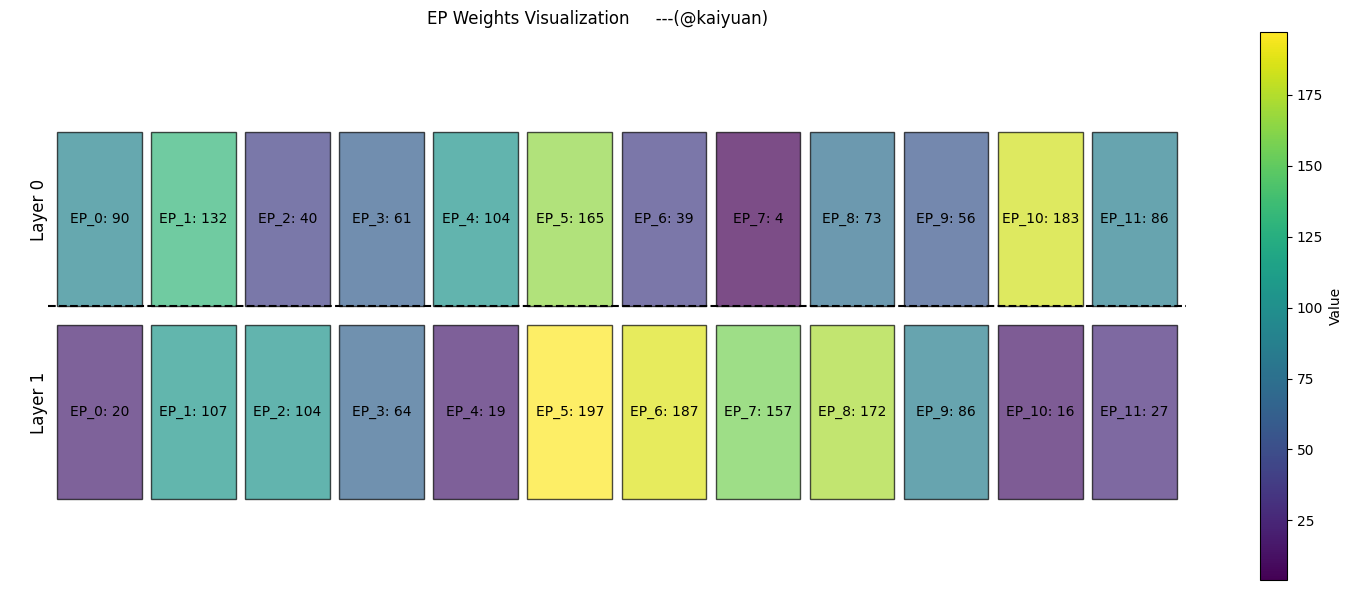

In [10]:
weight =[[ 90, 132,  40,  61, 104, 165,  39,   4,  73,  56, 183,  86],
     [ 20, 107, 104,  64,  19, 197, 187, 157, 172,  86,  16,  27]]
num_replicas = 16
num_groups = 4
num_nodes = 2
num_gpus = 8


phy2log, log2phy, logcnt = rebalance_experts(weight, num_replicas, num_groups, num_nodes, num_gpus)
np_phy2log = reshape_map(phy2log, num_nodes, num_gpus)
visualize_ep_inputs(weight)

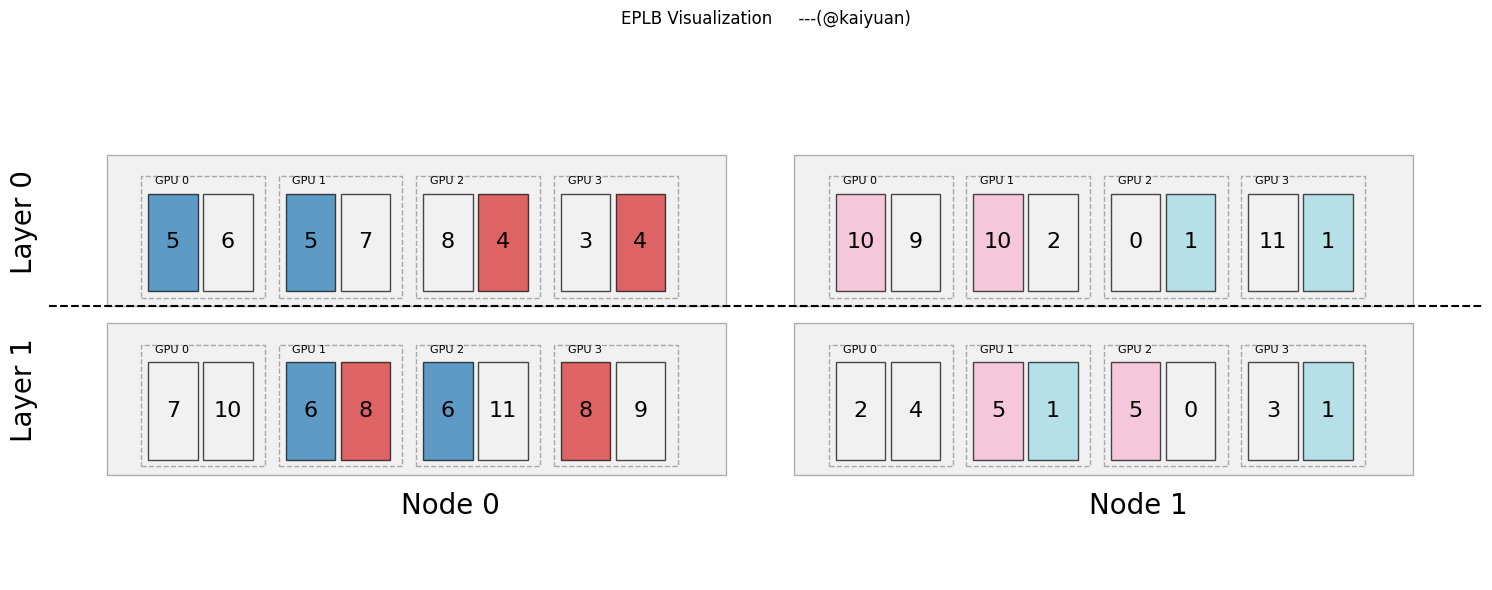

In [11]:
visualize_4d_array(np_phy2log)